In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from tensorflow import keras
from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings("ignore")

In [7]:
data = pd.read_csv('data/all_stocks_5yr.csv')
apple = data[data['Name'] == 'AAPL']
apple.head()

,date,open,high,low,close,volume,Name
1259,2013-02-08,67.7142,68.4014,66.8928,67.8542,158168416,AAPL
1260,2013-02-11,68.0714,69.2771,67.6071,68.5614,129029425,AAPL
1261,2013-02-12,68.5014,68.9114,66.8205,66.8428,151829363,AAPL
1262,2013-02-13,66.7442,67.6628,66.1742,66.7156,118721995,AAPL
1263,2013-02-14,66.3599,67.3771,66.2885,66.6556,88809154,AAPL


### preprocessing
1) drop rows with missing values

In [79]:
close_data = apple.filter(['close'])
dataset = close_data.values
training = int(np.ceil(len(dataset) * .95))
print(training)


1197


2) normalize data

In [80]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(dataset)

train_data = scaled_data[0:int(training), :]
# prepare feature and labels
x_train = []
y_train = []

for i in range(60, len(train_data)):
	x_train.append(train_data[i-60:i, 0])
	y_train.append(train_data[i, 0])

x_train, y_train = np.array(x_train), np.array(y_train)
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))


3) split data into train and test sets

In [81]:
model = keras.models.Sequential()
model.add(keras.layers.LSTM(units=64,
							return_sequences=True,
							input_shape=(x_train.shape[1], 1)))
model.add(keras.layers.LSTM(units=64))
model.add(keras.layers.Dense(32))
model.add(keras.layers.Dropout(0.5))
model.add(keras.layers.Dense(1))
model.summary


<bound method Model.summary of <keras.src.engine.sequential.Sequential object at 0x000001B11F93DA10>>

4. create sequences of length 10

In [82]:
model.compile(optimizer='adam',
			loss='mean_squared_error')
history = model.fit(x_train,
					y_train,
					epochs=10)


Epoch 1/10
36/36 [==============================] - 22s 167ms/step - loss: 0.0300
Epoch 2/10
36/36 [==============================] - 7s 203ms/step - loss: 0.0091
Epoch 3/10
36/36 [==============================] - 7s 208ms/step - loss: 0.0094
Epoch 4/10
36/36 [==============================] - 7s 195ms/step - loss: 0.0089
Epoch 5/10
36/36 [==============================] - 6s 178ms/step - loss: 0.0077
Epoch 6/10
36/36 [==============================] - 7s 178ms/step - loss: 0.0079
Epoch 7/10
36/36 [==============================] - 5s 135ms/step - loss: 0.0068
Epoch 8/10
36/36 [==============================] - 5s 148ms/step - loss: 0.0074
Epoch 9/10
36/36 [==============================] - 5s 151ms/step - loss: 0.0068
Epoch 10/10
36/36 [==============================] - 5s 139ms/step - loss: 0.0056


In [83]:
test_data = scaled_data[training - 60:, :]
x_test = []
y_test = dataset[training:, :]
for i in range(60, len(test_data)):
	x_test.append(test_data[i-60:i, 0])

x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

# predict the testing data
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)

# evaluation metrics
mse = np.mean(((predictions - y_test) ** 2))
print("MSE", mse)
print("RMSE", np.sqrt(mse))


2/2 [==============================] - 3s 45ms/step
MSE 0.0017256465921502268
RMSE 0.04154090264005137


### build RNN model with LSTM

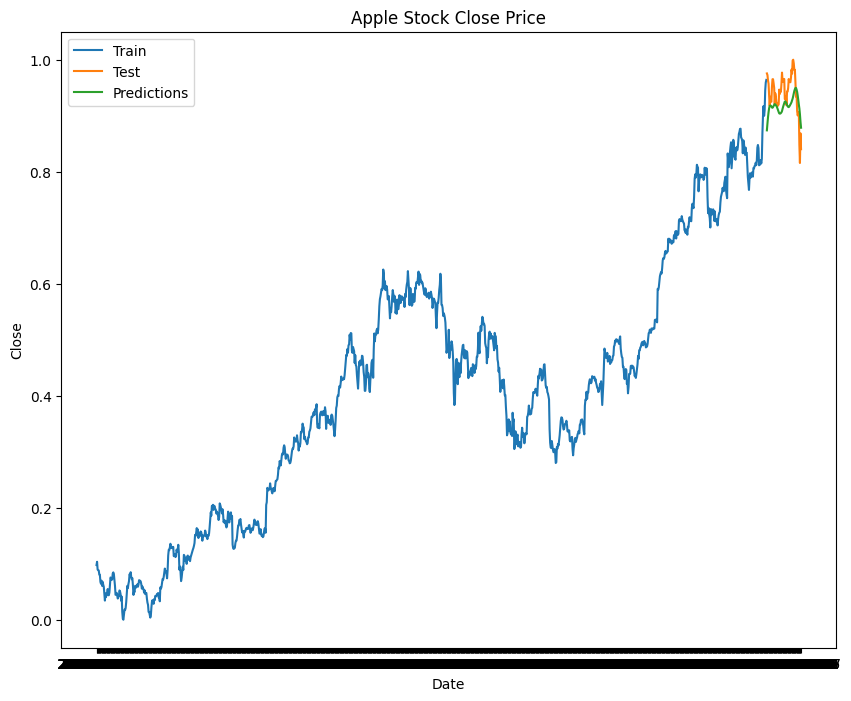

In [87]:
train = apple[:training]
test = apple[training:]
test['Predictions'] = predictions

plt.figure(figsize=(10, 8))
plt.plot(train['date'], train['close'])
plt.plot(test['date'], test[['close', 'Predictions']])
plt.title('Apple Stock Close Price')
plt.xlabel('Date')
plt.ylabel("Close")
plt.legend(['Train', 'Test', 'Predictions'])
